## Física Computacional: Tarea 1
Profesor: Pablo Benítez Llambay

Integrantes:
- Martín Raguileo Reyes
- Fernando Zamora Carrasco

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## 1. **Implementación Numérica**

### Modelo de Lotka-Volterra

In [2]:
# Función para modelar la tasa de población de las presas.
def prey_poblation(a: float, b: float, p: int, P: int) -> float:
    """
    Calcula la tasa de cambio de la población de presas según el modelo Lotka-Volterra.

    Parámetros:
    ----------
        a (float): Tasa de crecimiento de las presas.
        b (float): Tasa de depredación.
        p (int): Población de presas.
        P (int): Población de depredadores.

    Retorna:
    -------
        float: Tasa de cambio de la población de presas.
    """
    return (a * p) - (b * p * P)

# Función para modelar la tasa de población de los depredadores.
def depr_poblation(b: float, m: float, p: int, P: int, eps: float) -> float:
    """
    Calcula la tasa de cambio de la población de depredadores según el modelo Lotka-Volterra.

    Parámetros:
    ----------
        b (float): Tasa de depredación.
        m (float): Tasa de mortalidad de depredadores.
        p (int): Población de presas.
        P (int): Población de depredadores.
        eps (float): Eficiencia de conversión de presas en depredadores.

    Retorna:
    -------
        float: Tasa de cambio de la población de depredadores.
    """
    return (eps * b * p * P) - (m * P)

# Función para modelar la dinámica del sistema Lotka-Volterra.
def lotka_volterra(t: float, y: list[float], params: dict) -> list[float]:
    """
    Calcula las derivadas de las poblaciones de presas y depredadores en el modelo Lotka-Volterra.

    Parámetros:
    ----------
        t (float): Tiempo actual (no se usa en el cálculo).
        y (list[float]): Lista con las poblaciones actuales [presas, depredadores].
        params (dict): Diccionario con los parámetros del modelo (a, b, m, eps).

    Retorna:
    -------
        list[float]: Lista con las tasas de cambio [dp/dt, dP/dt].
    """
    p, P = y
    a, b, m, eps = params['a'], params['b'], params['m'], params['eps']

    dpdt = prey_poblation(a, b, p, P)
    dPdt = depr_poblation(b, m, p, P, eps)

    return [dpdt, dPdt]

### Funciones para los métodos numéricos

In [3]:
# Implementación del método de Euler.
def euler_step(f: Callable, t: float, y: list[float], dt: float, params: dict) -> list[float]:
    """
    Realiza un paso del método de Euler para resolver una ecuación diferencial ordinaria.

    Parámetros:
    ----------
        f (Callable): Función que calcula las derivadas.
        t (float): Tiempo actual.
        y (list[float]): Lista con los valores actuales de las variables dependientes.
        dt (float): Paso de tiempo.
        params (dict): Diccionario con parámetros adicionales para la función f.

    Retorna:
    -------
        list[float]: Lista con los nuevos valores de las variables dependientes después del paso.
    """
    dydt = f(t, y, params)
    return [y[i] + dt * dydt[i] for i in range(len(y))]

# Implementación del método de Runge-Kutta de segundo orden (RK2).
def rk2_step(f: Callable, t: float, y: list[float], dt: float, params: dict) -> list[float]:
    """
    Realiza un paso del método de Runge-Kutta de segundo orden para resolver una ecuación diferencial ordinaria.

    Parámetros:
    ----------
        f (Callable): Función que calcula las derivadas.
        t (float): Tiempo actual.
        y (list[float]): Lista con los valores actuales de las variables dependientes.
        dt (float): Paso de tiempo.
        params (dict): Diccionario con parámetros adicionales para la función f.

    Retorna:
    -------
        list[float]: Lista con los nuevos valores de las variables dependientes después del paso.
    """
    k1 = [dt * val for val in f(t, y, params)]
    k2 = [dt * val for val in f(t + dt, [y[i] + k1[i] for i in range(len(y))], params)]

    return [y[i] + (k1[i] + k2[i]) / 2 for i in range(len(y))]

# Implementación del método de Runge-Kutta de cuarto orden (RK4).
def rk4_step(f: Callable, t: float, y: list[float], dt: float, params: dict) -> list[float]:
    """
    Realiza un paso del método de Runge-Kutta de cuarto orden para resolver una ecuación diferencial ordinaria.

    Parámetros:
    ----------
        f (Callable): Función que calcula las derivadas.
        t (float): Tiempo actual.
        y (list[float]): Lista con los valores actuales de las variables dependientes.
        dt (float): Paso de tiempo.
        params (dict): Diccionario con parámetros adicionales para la función f.

    Retorna:
    -------
        list[float]: Lista con los nuevos valores de las variables dependientes después del paso.
    """
    k1 = [dt * val for val in f(t, y, params)]
    k2 = [dt * val for val in f(t + (dt/2), [y[i] + (k1[i]/2) for i in range(len(y))], params)]
    k3 = [dt * val for val in f(t + (dt/2), [y[i] + (k2[i]/2) for i in range(len(y))], params)]
    k4 = [dt * val for val in f(t + dt, [y[i] + k3[i]for i in range(len(y))], params)]

    return [y[i] + ((k1[i] + 2*k2[i] + 2*k3[i] + k4[i]) / 6) for i in range(len(y))]

### Comparación de las soluciones de los diferentes métodos numéricos.

In [4]:
# Parámetros del modelo Lotka-Volterra. Fueron elegidos de forma arbitraria.
params = {
  'a': 0.05,
  'b': 0.003,
  'm': 0.01,
  'eps': 0.02,
  'K': 1_500
}

# Condiciones iniciales: 40 presas y 25 depredadores.
p0, P0 = 40, 25
y_eu, y_rk2, y_rk4 = [p0, P0], [p0, P0], [p0, P0]

# Configuración de la simulación. Paso de tiempo y número total de pasos.
dt = 0.01
T = 50_000
steps = int(T/dt)

# Listas para almacenar los resultados.
times_eu, times_rk2, times_rk4 = [], [], []
prey_eu, prey_rk2, prey_rk4 = [], [], []
predators_eu, predators_rk2, predators_rk4 = [], [], []

t = 0
for _ in range(steps):
    # Almacenamos los tiempos para cada método.
    times_eu.append(t)
    times_rk2.append(t)
    times_rk4.append(t)

    # Almacenamos las poblaciones de presas para cada método.
    prey_eu.append(y_eu[0])
    prey_rk2.append(y_rk2[0])
    prey_rk4.append(y_rk4[0])

    # Almacenamos las poblaciones de depredadores para cada método.
    predators_eu.append(y_eu[1])
    predators_rk2.append(y_rk2[1])
    predators_rk4.append(y_rk4[1])

    # Actualizamos las poblaciones usando cada método numérico.
    y_eu = euler_step(lotka_volterra, t, y_eu, dt, params)
    y_rk2 = rk2_step(lotka_volterra, t, y_rk2, dt, params)
    y_rk4 = rk4_step(lotka_volterra, t, y_rk4, dt, params)
    t += dt

# Cálculo de las relaciones de equilibrio.
R_e = params['m'] / (params['eps'] * params['b'])
F_e = params['a'] / params['b']

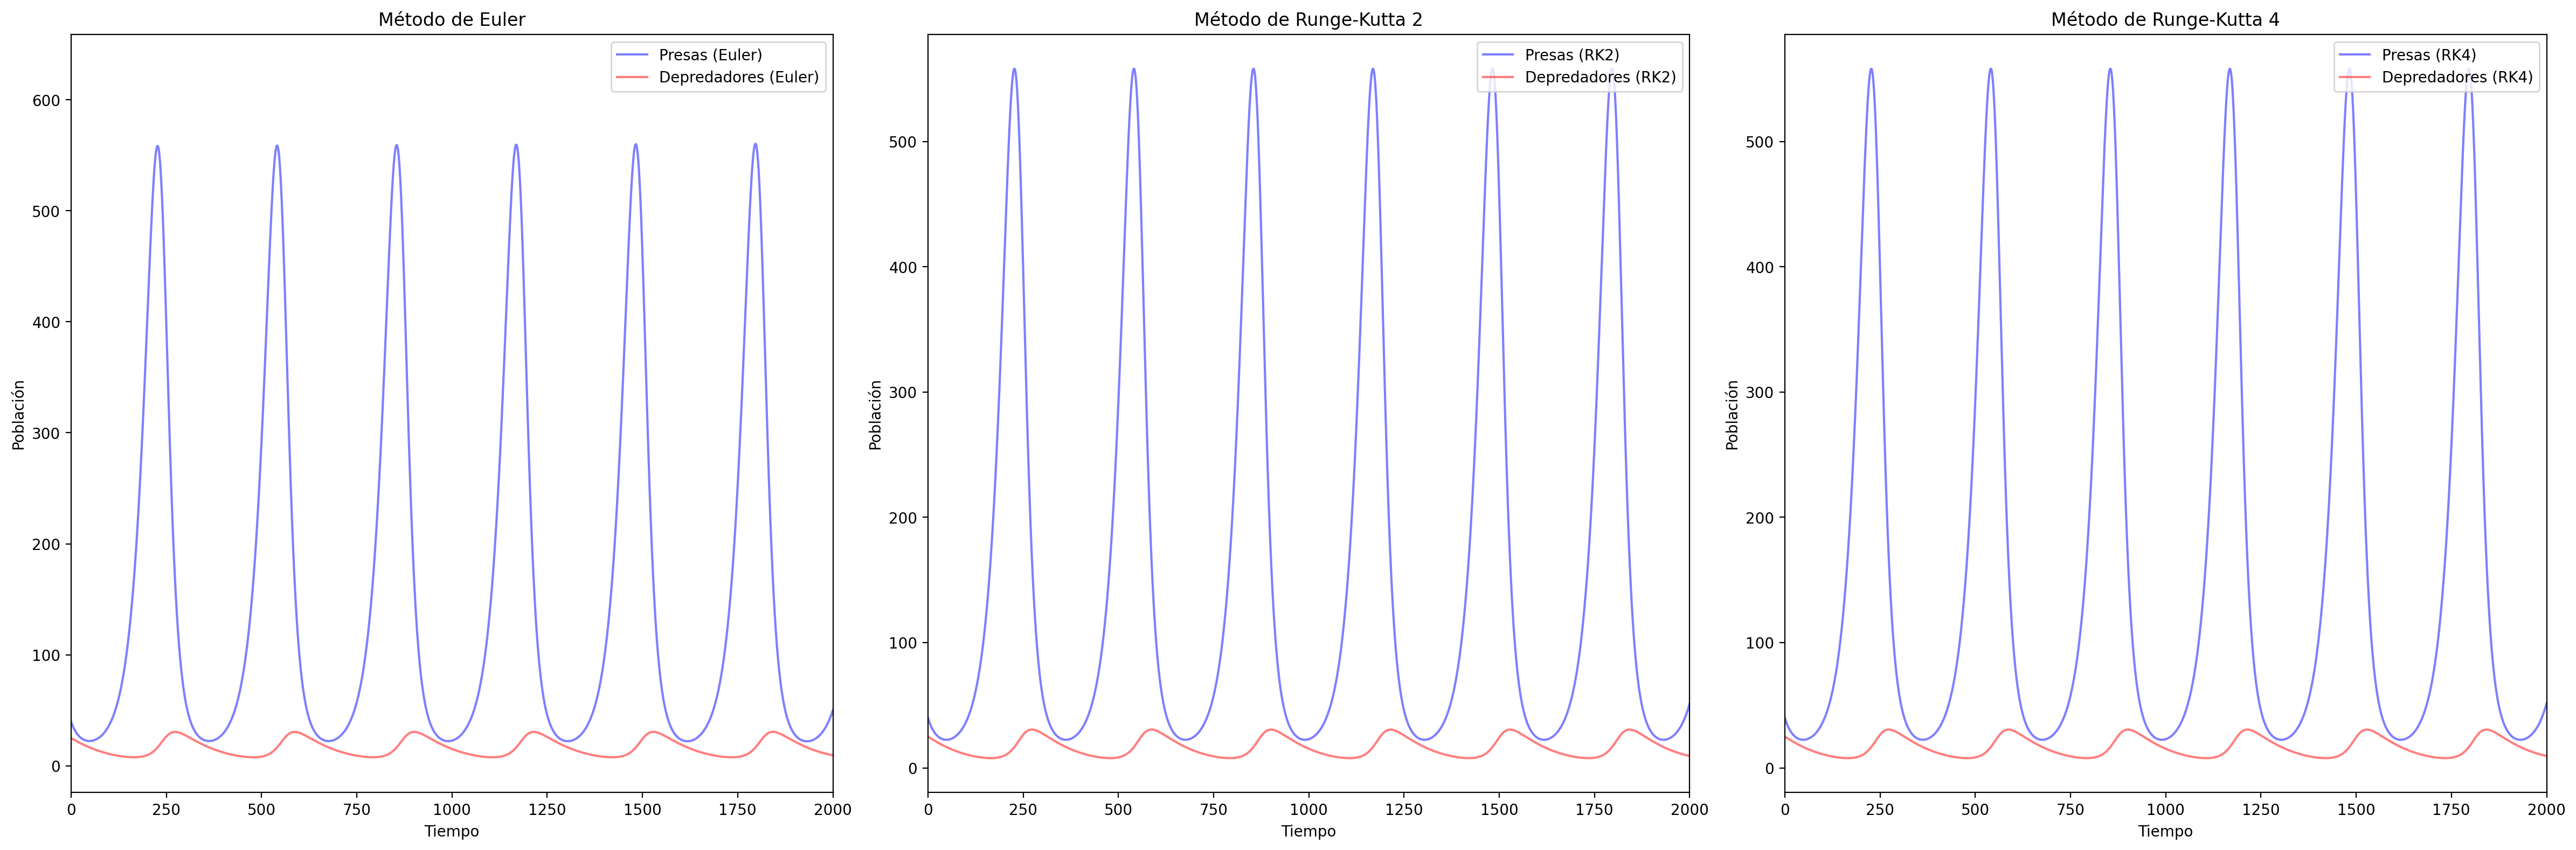

In [24]:
plt.figure(figsize=(24, 8))
plt.subplot(1, 3, 1)
plt.plot(times_eu, prey_eu, label='Presas (Euler)', color='blue', alpha=0.5)
plt.plot(times_eu, predators_eu, label='Depredadores (Euler)', color='red', alpha=0.5)
plt.xlabel('Tiempo')
plt.xlim(0, 2_000)
plt.ylabel('Población')
plt.legend(loc='upper right')
plt.title('Método de Euler')

plt.subplot(1, 3, 2)
plt.plot(times_rk2, prey_rk2, label='Presas (RK2)', color='blue', alpha=0.5)
plt.plot(times_rk2, predators_rk2, label='Depredadores (RK2)', color='red', alpha=0.5)
plt.xlabel('Tiempo')
plt.xlim(0, 2_000)
plt.ylabel('Población')
plt.legend(loc='upper right')
plt.title('Método de Runge-Kutta 2')

plt.subplot(1, 3, 3)
plt.plot(times_rk4, prey_rk4, label='Presas (RK4)', color='blue', alpha=0.5)
plt.plot(times_rk4, predators_rk4, label='Depredadores (RK4)', color='red', alpha=0.5)
plt.xlabel('Tiempo')
plt.xlim(0, 2_000)
plt.ylabel('Población')
plt.legend(loc='upper right')
plt.title('Método de Runge-Kutta 4')

plt.tight_layout()
plt.show();

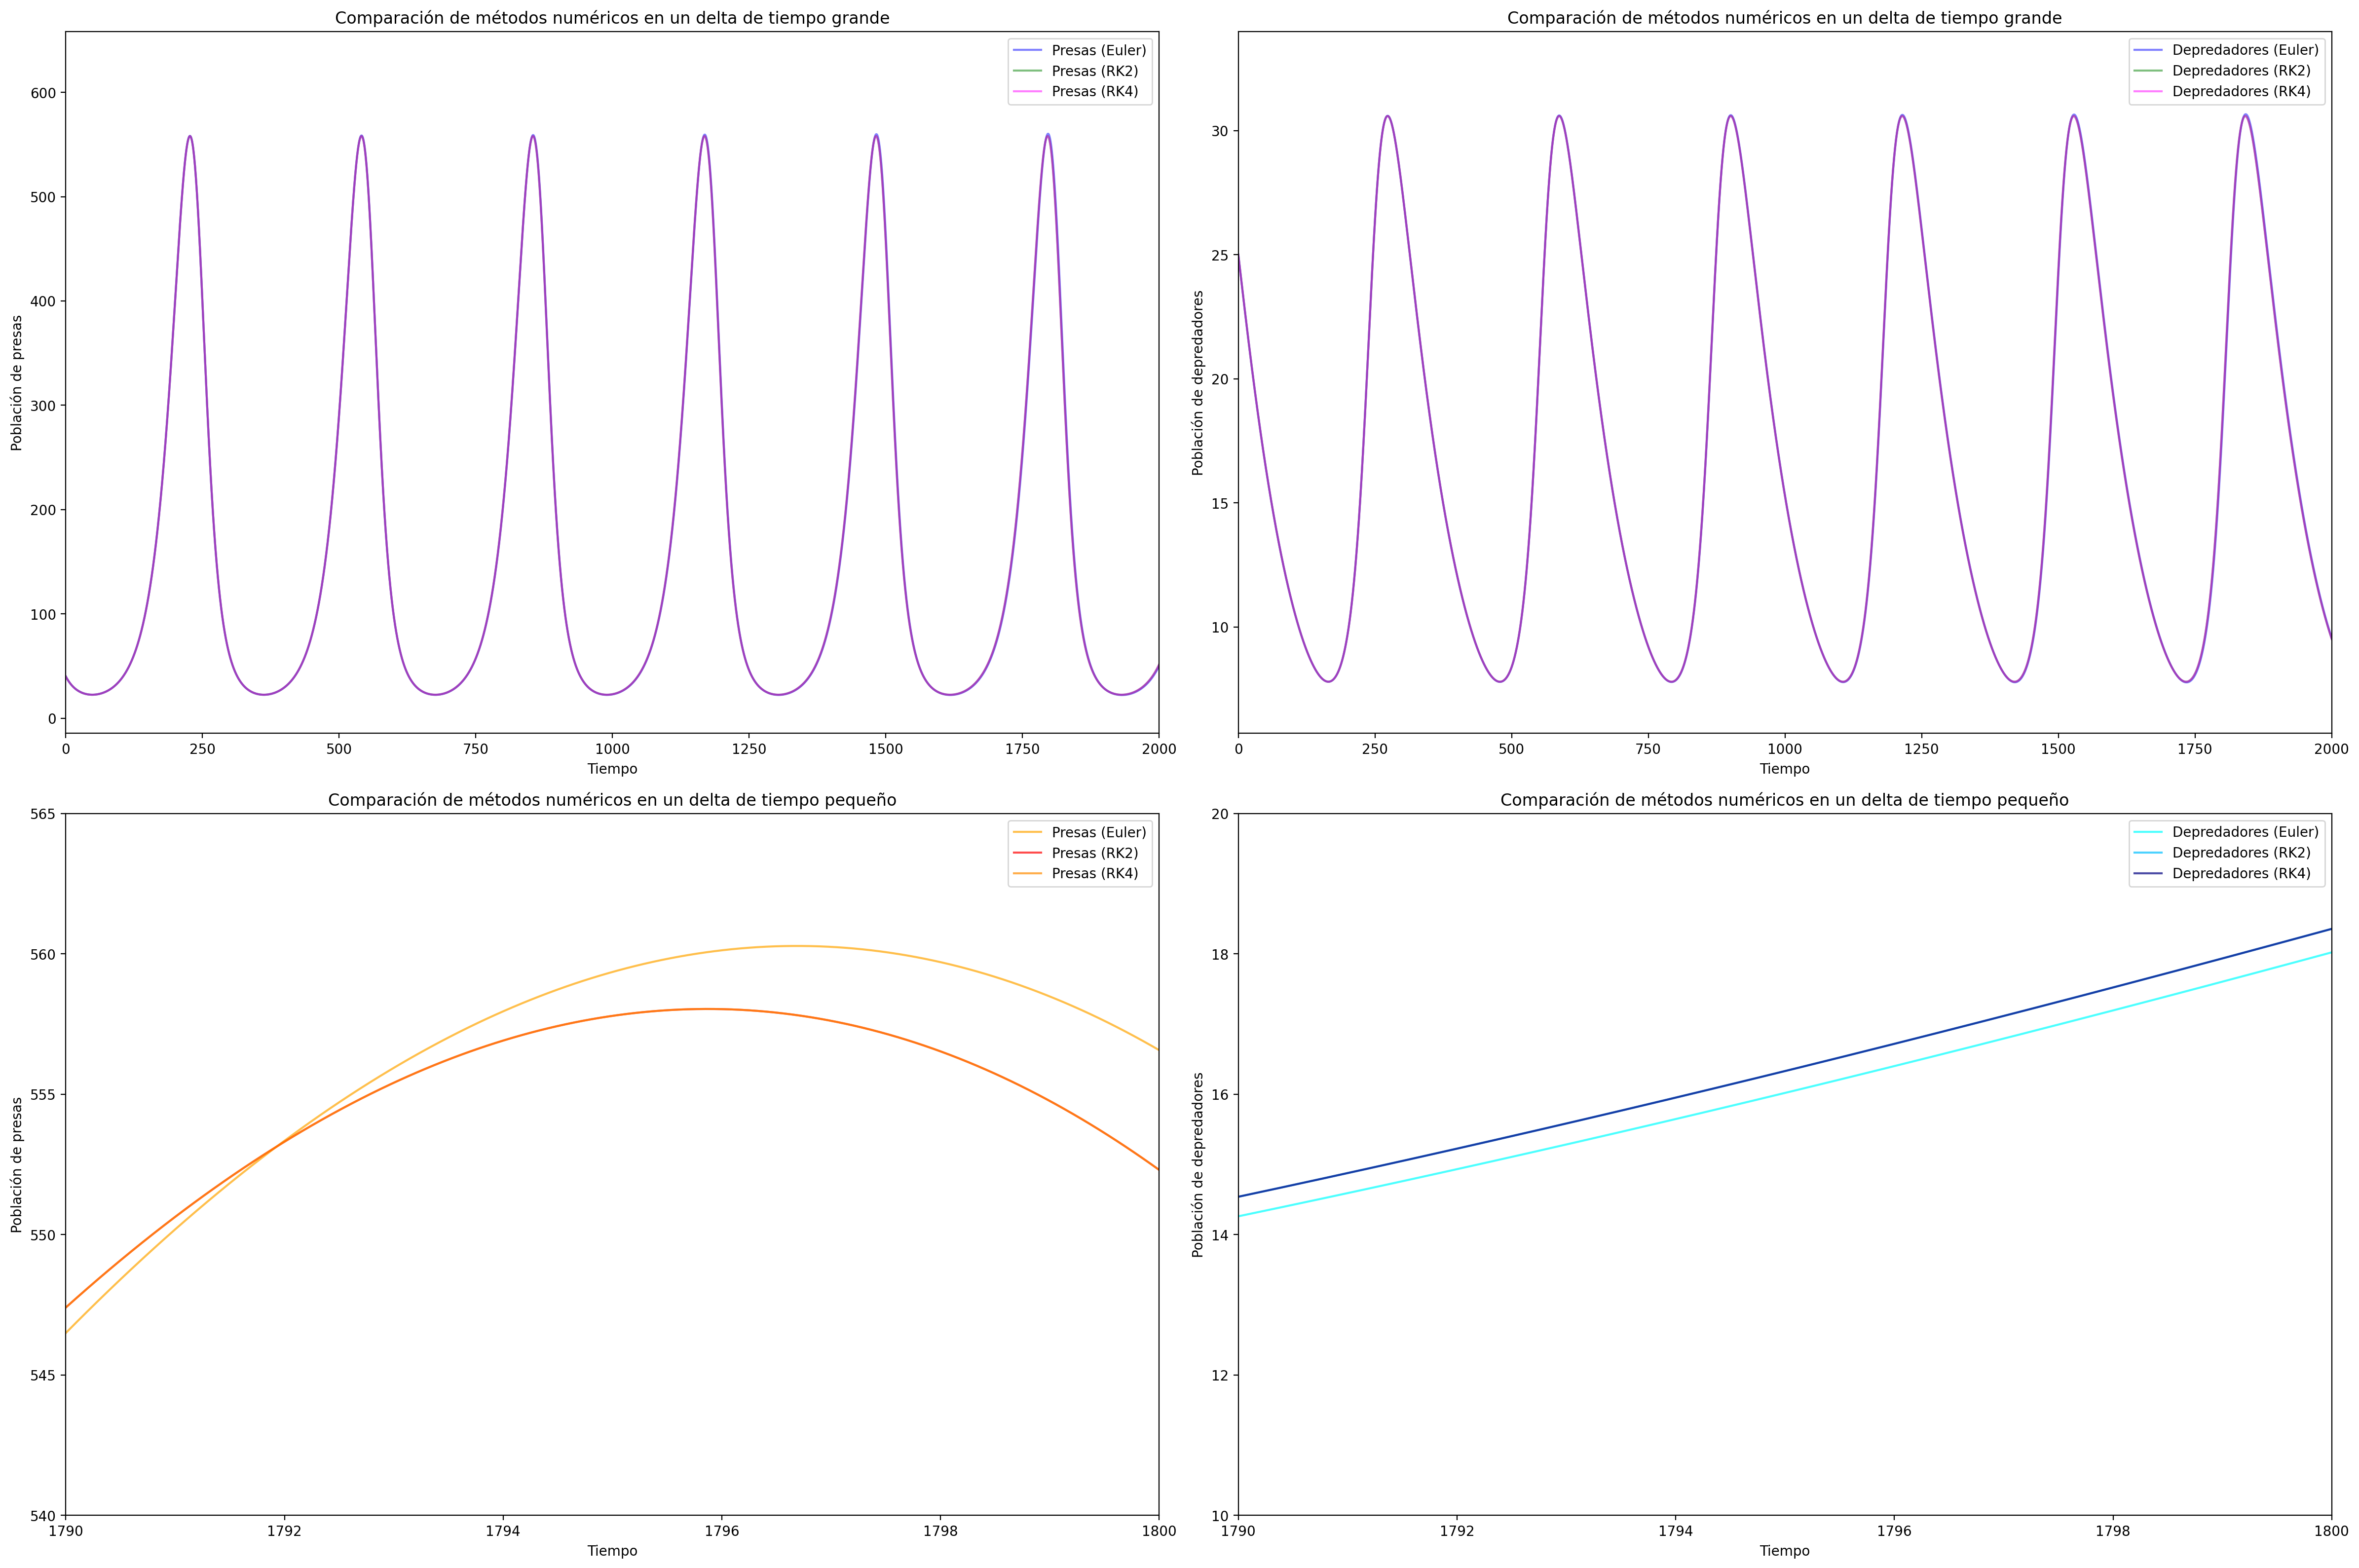

In [41]:
plt.figure(figsize=(24, 16))

plt.subplot(2, 2, 1)
plt.plot(times_eu, prey_eu, label='Presas (Euler)', color='blue', alpha=0.5)
plt.plot(times_rk2, prey_rk2, label='Presas (RK2)', color='green', alpha=0.5)
plt.plot(times_rk4, prey_rk4, label='Presas (RK4)', color='magenta', alpha=0.5)
plt.xlabel('Tiempo')
plt.xlim(0, 2_000)
plt.ylabel('Población de presas')
plt.legend(loc='upper right')
plt.title('Comparación de métodos numéricos en un delta de tiempo grande')

plt.subplot(2, 2, 2)
plt.plot(times_eu, predators_eu, label='Depredadores (Euler)', color='blue', alpha=0.5)
plt.plot(times_rk2, predators_rk2, label='Depredadores (RK2)', color='green', alpha=0.5)
plt.plot(times_rk4, predators_rk4, label='Depredadores (RK4)', color='magenta', alpha=0.5)
plt.xlabel('Tiempo')
plt.xlim(0, 2_000)
plt.ylabel('Población de depredadores')
plt.legend(loc='upper right')
plt.title('Comparación de métodos numéricos en un delta de tiempo grande')

plt.subplot(2, 2, 3)
plt.plot(times_eu, prey_eu, label='Presas (Euler)', color='orange', alpha=0.7)
plt.plot(times_rk2, prey_rk2, label='Presas (RK2)', color='red', alpha=0.7)
plt.plot(times_rk4, prey_rk4, label='Presas (RK4)', color='darkorange', alpha=0.7)
plt.xlabel('Tiempo')
plt.xlim(1_790, 1_800)
plt.ylabel('Población de presas')
plt.ylim(540, 565)
plt.yticks(np.arange(540, 566, 5))
plt.legend(loc='upper right')
plt.title('Comparación de métodos numéricos en un delta de tiempo pequeño')

plt.subplot(2, 2, 4)
plt.plot(times_eu, predators_eu, label='Depredadores (Euler)', color='cyan', alpha=0.7)
plt.plot(times_rk2, predators_rk2, label='Depredadores (RK2)', color='deepskyblue', alpha=0.7)
plt.plot(times_rk4, predators_rk4, label='Depredadores (RK4)', color='navy', alpha=0.7)
plt.xlabel('Tiempo')
plt.xlim(1_790, 1_800)
plt.ylabel('Población de depredadores')
plt.ylim(10, 20)
plt.legend(loc='upper right')
plt.title('Comparación de métodos numéricos en un delta de tiempo pequeño')

plt.tight_layout()
plt.show();

In [42]:
## Acá va a ir una killer animation donde vemos la evolución de las poblaciones a través del tiempo y cómo varían según el método numérico utilizado.
# --- IGNORE ---

## 2. **Análisis del Paso de Tiempo**

## 3. **Análisis de Error**

## 4. **Diagrama de Fase**

## 5. **Análisis de Parámetros**

## 6. **Conclusiones**